# Purpose
* reproduce the Bayesian anlysis of variance (ANOVA) from John K. Kruschke Doing Bayesian Data Aanalysis from Chapter 20
* Starting from [Python notebook from github repo DBDA-python Chapter 20](https://github.com/JWarmenhoven/DBDA-python/blob/master/Notebooks/Chapter%2020.ipynb)
* Want to also reproduce the results using a cell means model

In [1]:
import arviz as az
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from jax import numpy as jnp
from jax import random
from matplotlib import pyplot as plt
from scipy.stats import norm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

import numpyro
from numpyro import distributions as dist
from numpyro.distributions import constraints
from numpyro.infer import MCMC, NUTS, Predictive

plt.style.use("seaborn")
color = "#87ceeb"

In [2]:
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt(mode ** 2 + 4 * sd ** 2)) / (2 * sd ** 2)
    shape = 1 + mode * rate
    return (shape, rate)

In [3]:
def plot_mustache(var, sd, j, width=0.75, ax=None):
    for i in np.arange(0, len(var), int(len(var) * 0.1)):
        rv = norm(loc=var[i], scale=sd[i])
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        xrange = rv.pdf(yrange)

        # When the SD of a group is large compared to others, then the top of its mustache is relatively
        # low and does not plot well together with low SD groups.
        # Scale the xrange so that the 'height' of the all mustaches is 0.75
        xrange_scaled = xrange * (width / xrange.max())

        # Using the negative value to flip the mustache in the right direction.
        ax.plot(-xrange_scaled + j, yrange, color=color, alpha=0.6, zorder=99)

```python
def cell_means_00(factor_00, factor_01, y_sd, y=None):
    num_data = factor_00.shape[0]
    num_factor_00 = len(set(factor_00))
    num_factor_01 = len(set(factor_01))

    sigma = numpyro.sample("sigma", dist.Uniform(low=y_sd / 100, high=y_sd * 10))

    with numpyro.plate("num_factor_01", num_factor_01):
        with numpyro.plate("num_factor_00", num_factor_00):
            cell_mean = numpyro.sample("cell_mean", dist.Normal(0, 1000))

    with numpyro.plate("num_data", num_data):
        numpyro.sample(
            "obs", dist.Normal(cell_mean[factor_00, factor_01], sigma), obs=y
        )
```

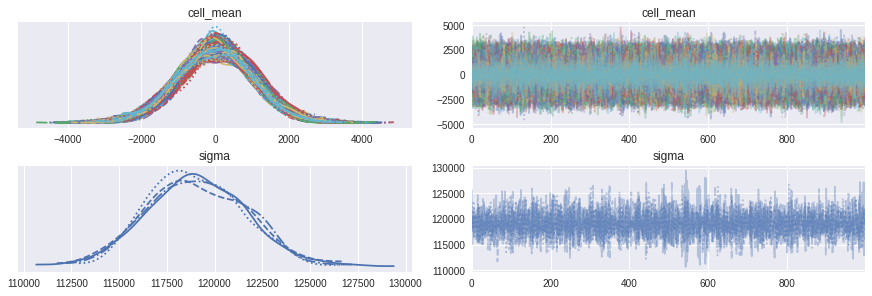

* first attempt, was trying to fit the model on original scale (dollars)
* trying to pick the range of sigma from the original post and from DBDA textbook
* cell means seem to not to move off the prior
* going to fit on a standardize scale

```python
def cell_means_01(factor_00, factor_01, y=None):
    num_data = factor_00.shape[0]
    num_factor_00 = len(set(factor_00))
    num_factor_01 = len(set(factor_01))

    sigma = numpyro.sample("sigma", dist.Exponential(1))

    with numpyro.plate("num_factor_01", num_factor_01):
        with numpyro.plate("num_factor_00", num_factor_00):
            cell_mean = numpyro.sample("cell_mean", dist.Normal(0, 10))

    with numpyro.plate("num_data", num_data):
        numpyro.sample(
            "obs", dist.Normal(cell_mean[factor_00, factor_01], sigma), obs=y
        )
```

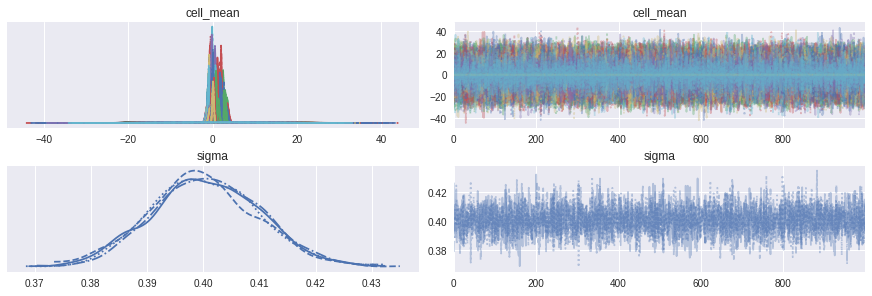

* The cell means are now standardized
* Standard deviation is now an Exponential with rate 1
* Cell means don't have a share standard deviation
* looks like the means don't move off of zero

```python

```

In [4]:
num_warmup = 500
num_samples = 1000
num_chains = 4

In [5]:
salary = pd.read_csv(
    "https://raw.githubusercontent.com/JWarmenhoven/DBDA-python/master/Notebooks/data/Salary.csv",
    usecols=[0, 3, 5],
    dtype={"Org": "category", "Pos": "category", "Salary": float},
)
salary["Pos"] = salary.Pos.cat.reorder_categories(
    ["FT3", "FT2", "FT1", "NDW", "DST"], ordered=True,
)
salary["Pos"] = salary.Pos.cat.rename_categories(
    ["Assis", "Assoc", "Full", "Endow", "Disting"],
)
salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Org     1080 non-null   category
 1   Pos     1080 non-null   category
 2   Salary  1080 non-null   float64 
dtypes: category(2), float64(1)
memory usage: 13.4 KB


In [6]:
salary.groupby("Pos").apply(lambda x: x.head(2))

Org      Pos    Salary
Pos                                 
Assis   4    LGED    Assis   63796.0
        6    INFO    Assis   98814.0
Assoc   0      PL    Assoc   72395.0
        1    MUTH    Assoc   61017.0
Full    7    CRIN     Full  107745.0
        9     PSY     Full  173302.0
Endow   5    MGMT    Endow  219600.0
        8    CRIN    Endow  114275.0
Disting 29   SPEA  Disting  285000.0
        128  MUHI  Disting  114189.0

In [7]:
salary["Pos_ID"] = salary.Pos.cat.codes
salary["Org_ID"] = salary.Org.cat.codes
salary

,Org,Pos,Salary,Pos_ID,Org_ID
0,PL,Assoc,72395.0,1,46
1,MUTH,Assoc,61017.0,1,41
2,ENG,Assoc,82370.0,1,20
3,CMLT,Assoc,68805.0,1,14
4,LGED,Assis,63796.0,0,33
...,...,...,...,...,...
1075,CSCI,Assis,92500.0,0,16
1076,PHYS,Assis,76748.0,0,45
1077,GEOL,Full,105786.0,2,26
1078,BI,Full,116592.0,2,8


In [8]:
def plot_figure_20pt3(df, *, subset_org, order_swarmplot, y_lim, post_samples = None):
    fg = sns.FacetGrid(df, col="Org", col_order=subset_org, col_wrap=2, height=3.5, aspect=1.3, despine=False, sharex=False,)
    fg.map(sns.swarmplot, "Pos", "Salary", data=df, color="r", order=order_swarmplot, size=4.5,)
    fg.fig.suptitle("Data with Posterior Prediction", y=1.05, fontsize=16)

    for ax in fg.axes:
        ax.set_xlim(xmin=-1,)
        ax.set_ylim(y_lim)
        
    if post_samples is not None:
        loc, scale = post_samples
        for i, org_idx in enumerate([7, 12, 48, 20]):
            for pos_idx in np.arange(5):
                plot_mustache(loc[:, pos_idx, org_idx], scale, pos_idx, ax=fg.axes.flatten()[i],)

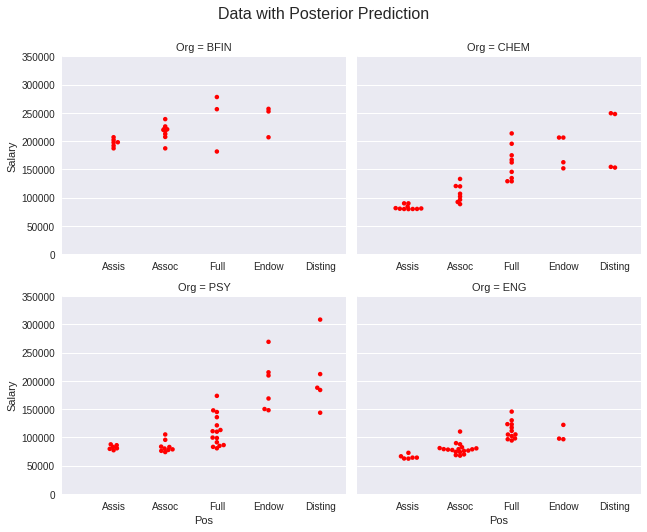

In [9]:
plot_figure_20pt3(salary, subset_org=["BFIN", "CHEM", "PSY", "ENG"], order_swarmplot=["Assis", "Assoc", "Full", "Endow", "Disting"], y_lim=(0, 350000))

In [10]:
# # BFIN = 7
# # CHEM = 12
# # PSY = 48
# # ENG = 20
# subset_org = ["BFIN", "CHEM", "PSY", "ENG"]
# subset_df = salary[salary.Org.isin(subset_org)].copy()

# fg = sns.FacetGrid(
#     subset_df,
#     col="Org",
#     col_order=subset_org,
#     col_wrap=2,
#     height=3.5,
#     aspect=1.3,
#     despine=False,
#     sharex=False,
# )
# fg.map(
#     sns.swarmplot,
#     "Pos",
#     "Salary",
#     data=subset_df,
#     color="r",
#     order=["Assis", "Assoc", "Full", "Endow", "Disting"],
#     size=4.5,
# )
# fg.fig.suptitle("Data with Posterior Prediction", y=1.05, fontsize=16)

# for ax in fg.axes:
#     ax.set_xlim(xmin=-1,)
#     ax.set_ylim((0, 350000))

In [11]:
ct = ColumnTransformer(
    [
        ("standard_salary", StandardScaler(), ["Salary"]),
        ("ordinal_encoder", OrdinalEncoder(), ["Org", "Pos"]),
    ]
)
salary_trf = pd.DataFrame(ct.fit_transform(salary), columns=["Salary", "Org", "Pos"],)
salary_trf = salary_trf.astype(dtype={"Org": int, "Pos": int, "Salary": float},)
salary_trf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Salary  1080 non-null   float64
 1   Org     1080 non-null   int64  
 2   Pos     1080 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 25.4 KB


In [12]:
# # BFIN = 7
# # CHEM = 12
# # PSY = 48
# # ENG = 20
# subset_org = [7, 12, 48, 20]
# subset_df = salary_trf[salary_trf.Org.isin(subset_org)].copy()

# fg = sns.FacetGrid(
#     subset_df,
#     col="Org",
#     col_order=subset_org,
#     col_wrap=2,
#     height=3.5,
#     aspect=1.3,
#     despine=False,
#     sharex=False,
# )
# fg.map(
#     sns.swarmplot,
#     "Pos",
#     "Salary",
#     data=subset_df,
#     color="r",
#     order=[0, 1, 3, 4, 2],
#     size=4.5,
# )
# fg.fig.suptitle("Data with Posterior Prediction", y=1.05, fontsize=16)

# for ax in fg.axes:
#     ax.set_xlim(xmin=-1,)
#     ax.set_ylim((-2, 5))

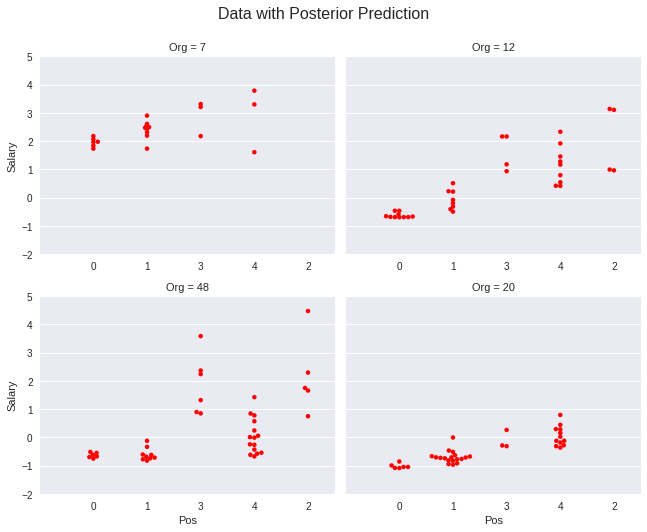

In [13]:
plot_figure_20pt3(salary_trf, subset_org=[7, 12, 48, 20], order_swarmplot=[0, 1, 3, 4, 2], y_lim=(-2, 5))

In [14]:
ct.named_transformers_["ordinal_encoder"].categories_[1]

array(['Assis', 'Assoc', 'Disting', 'Endow', 'Full'], dtype=object)

In [15]:
y = salary.Salary
yMean = y.mean()
ySD = y.std()
print(f"Salary mean and std. = ${yMean:.2f} +/- ${ySD:.2f}")

Salary mean and std. = $110452.00 +/- $44283.20


In [16]:
ySD / 100, ySD * 10

(442.83204578365417, 442832.0457836542)

In [17]:
ct.named_transformers_["standard_salary"].mean_, np.sqrt(
    ct.named_transformers_["standard_salary"].var_
)

(array([110452.0037037]), array([44262.69834685]))

## Priors

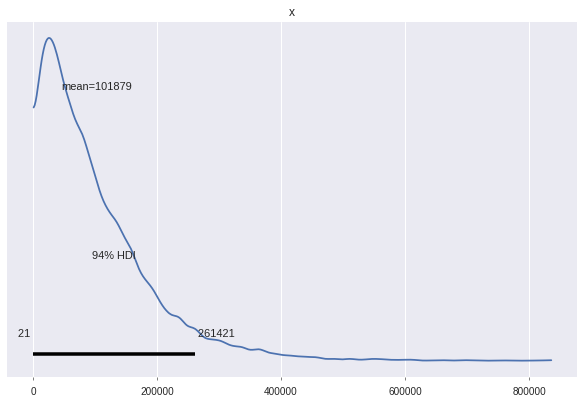

In [18]:
sd_ = gammaShRaFromModeSD(ySD / 2, 2 * ySD)
az.plot_posterior(
    np.array(dist.Gamma(sd_[0], sd_[1]).sample(random.PRNGKey(1), (10000,)))
);

In [19]:
ySD_trf = ct.named_transformers_["standard_salary"].transform(
    np.array(ySD).reshape(-1, 1)
)
ySD_trf = ySD_trf[0][0]

print(f"y std orig = {ySD:0.2f} | y std trf scale = {ySD_trf:0.2f}")

y std orig = 44283.20 | y std trf scale = -1.49


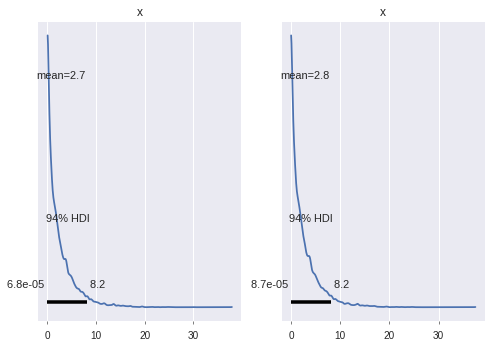

In [20]:
sd_ = gammaShRaFromModeSD(ySD_trf / 2, 2 * ySD_trf)

fig, ax = plt.subplots(1, 2)
az.plot_posterior(
    np.array(dist.Gamma(sd_[0], sd_[1]).sample(random.PRNGKey(1), (10000,))), ax=ax[0]
)
az.plot_posterior(
    np.array(dist.Gamma(0.8, 0.3).sample(random.PRNGKey(1), (10000,))), ax=ax[1]
);

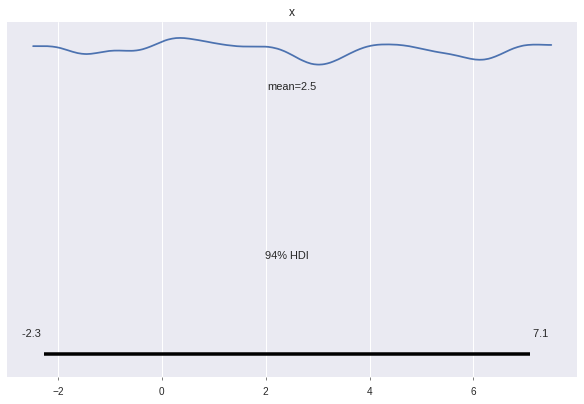

In [21]:
sd_ = ct.named_transformers_["standard_salary"].transform(
    np.array([ySD / 100, ySD * 10]).reshape(-1, 1)
)
az.plot_posterior(
    np.array(
        dist.Uniform(sd_[0, :][0], sd_[1, :][0]).sample(random.PRNGKey(1), (10000,))
    ),
);

In [22]:
sd_

array([[-2.48536975],
       [ 7.50925846]])

## Inference

In [23]:
def factor_effect(factor_00, factor_01, y_sigma, y_mean, y=None):
    num_data = factor_00.shape[0]
    num_factor_00 = len(set(factor_00))
    num_factor_01 = len(set(factor_01))
    
    a0_tilde = numpyro.sample("a0_tilde", dist.Normal(0, 1))
    a0 = numpyro.deterministic("a0", y_mean + y_sigma*5*a0_tilde)

    sigma_y = numpyro.sample("sigma_y", dist.Uniform(y_sigma/100, y_sigma*10))
    
    sd_ = gammaShRaFromModeSD(y_sigma / 2, 2 * y_sigma)
    
    with numpyro.plate("num_terms", 3):
        sigma = numpyro.sample("sigma", dist.Gamma(sd_[0], sd_[1]))
    
    with numpyro.plate("num_factor_00", num_factor_00):
        a1_tilde = numpyro.sample("a1_tilde", dist.Normal(0, 1))
        a1 = numpyro.deterministic("a1", 0.0 + sigma[0]*a1_tilde)
        
    with numpyro.plate("num_factor_01", num_factor_01):
        a2_tilde = numpyro.sample("a2_tilde", dist.Normal(0, 1))
        a2 = numpyro.deterministic("a2", 0.0 + sigma[1]*a2_tilde)

    with numpyro.plate("num_factor_01", num_factor_01):
        with numpyro.plate("num_factor_00", num_factor_00):
            a1a2_tilde = numpyro.sample("a1a2_tilde", dist.Normal(0, 1))
            a1a2 = numpyro.deterministic("a1a2", 0.0 + a1a2_tilde*sigma[2])

    with numpyro.plate("num_data", num_data):
        mu = numpyro.deterministic("mu", a0 + a1[factor_00] + a2[factor_01] + a1a2[factor_00, factor_01])
        numpyro.sample("obs", dist.Normal(mu, sigma_y), obs=y)

## Cell Means

In [24]:
def cell_means_02(factor_00, factor_01, y=None):
    num_data = factor_00.shape[0]
    num_factor_00 = len(set(factor_00))
    num_factor_01 = len(set(factor_01))

    sigma_y = numpyro.sample("sigma_y", dist.Exponential(1))

    sigma_cell = numpyro.sample("sigma_cell", dist.Gamma(0.8, 0.3))

    with numpyro.plate("num_factor_01", num_factor_01):
        with numpyro.plate("num_factor_00", num_factor_00):
            cell_mean = numpyro.sample("cell_mean", dist.Normal(0, sigma_cell))

    with numpyro.plate("num_data", num_data):
        numpyro.sample(
            "obs", dist.Normal(cell_mean[factor_00, factor_01], sigma_y), obs=y
        )

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:01<00:00, 908.56it/s, 15 steps of size 3.43e-01. acc. prob=0.85] 



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
 cell_mean[0,0]      1.62      0.15      1.62      1.37      1.85   9751.41      1.00
 cell_mean[0,1]     -0.01      1.03     -0.02     -1.60      1.74   9153.83      1.00
 cell_mean[0,2]     -1.02      0.23     -1.02     -1.42     -0.65   9141.98      1.00
 cell_mean[0,3]     -0.75      0.36     -0.75     -1.31     -0.12   8804.91      1.00
 cell_mean[0,4]     -0.79      0.17     -0.79     -1.08     -0.51  11543.53      1.00
 cell_mean[0,5]     -0.82      0.38     -0.82     -1.42     -0.20   9076.22      1.00
 cell_mean[0,6]      0.39      0.23      0.39      0.02      0.76  10049.44      1.00
 cell_mean[0,7]      1.92      0.16      1.92      1.66      2.18   9421.38      1.00
 cell_mean[0,8]     -0.74      0.12     -0.74     -0.94     -0.56  11802.57      1.00
 cell_mean[0,9]     -0.06      0.23     -0.06     -0.43      0.31  10229.66      1.00
cell_mean[0,10]     -0.95      0.15     -0.95     -1.

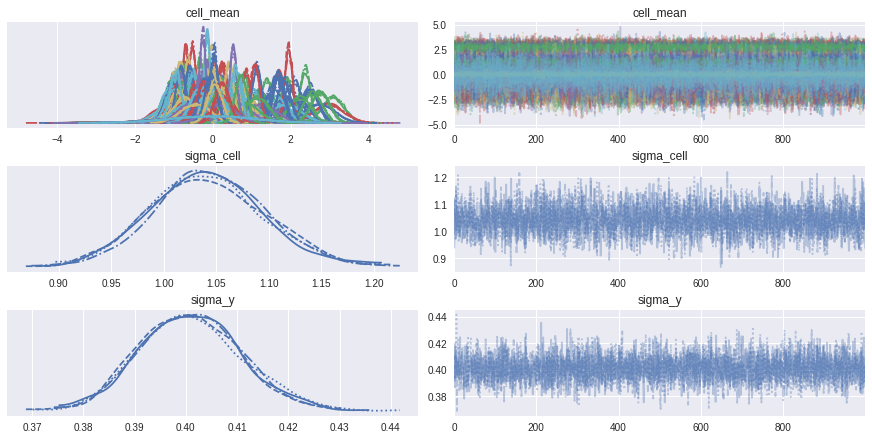

In [25]:
kernel = NUTS(cell_means_02)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(
    random.PRNGKey(4),
    jnp.array(salary_trf.Pos),
    jnp.array(salary_trf.Org),
    jnp.array(salary_trf.Salary),
)
mcmc.print_summary(exclude_deterministic=True)
ds_ = az.from_numpyro(mcmc)
az.plot_trace(ds_);

In [26]:
ct.named_transformers_["ordinal_encoder"].categories_[1].tolist()

['Assis', 'Assoc', 'Disting', 'Endow', 'Full']

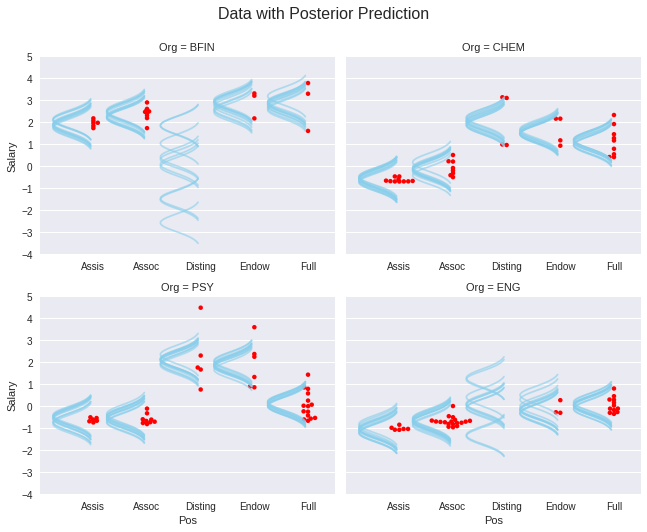

In [27]:
tmp = salary_trf.copy()
tmp["Org"] = tmp.Org.replace(
    {
        i: p
        for i, p in enumerate(ct.named_transformers_["ordinal_encoder"].categories_[0])
    }
)
tmp["Pos"] = tmp.Pos.replace(
    {
        i: p
        for i, p in enumerate(ct.named_transformers_["ordinal_encoder"].categories_[1])
    }
)


plot_figure_20pt3(
    tmp,
    subset_org=["BFIN", "CHEM", "PSY", "ENG"],
    order_swarmplot=ct.named_transformers_["ordinal_encoder"].categories_[1].tolist(),
    y_lim=(-4, 5),
    post_samples=(mcmc.get_samples()["cell_mean"], mcmc.get_samples()["sigma_y"]),
)

In [ ]:
# # BFIN = 7
# # CHEM = 12
# # PSY = 48
# # ENG = 20
# num_draws = 4000
# subset_idx = [7, 12, 48, 20]
# subset_df = salary_trf[salary_trf.Org.isin(subset_idx)].copy()
# subset_org = ["BFIN", "CHEM", "PSY", "ENG"]

# subset_df["Org"] = subset_df.Org.replace({7: "BFIN", 12: "CHEM", 48: "PSY", 20: "ENG"})
# subset_df["Pos"] = subset_df.Pos.replace(
#     {
#         i: p
#         for i, p in enumerate(ct.named_transformers_["ordinal_encoder"].categories_[1])
#     }
# )

# fg = sns.FacetGrid(
#     subset_df,
#     col="Org",
#     col_order=subset_org,
#     col_wrap=2,
#     height=3.5,
#     aspect=1.3,
#     despine=False,
#     sharex=False,
# )
# fg.map(
#     sns.swarmplot,
#     "Pos",
#     "Salary",
#     data=subset_df,
#     color="r",
#     order=ct.named_transformers_["ordinal_encoder"].categories_[1].tolist(),
#     size=4.5,
# )
# fg.fig.suptitle("Data with Posterior Prediction", y=1.05, fontsize=16)

# for ax in fg.axes:
#     ax.set_xlim(xmin=-1, xmax=5)
#     ax.set_xticks(range(5),)
#     # ax.set_xticklabels(ct.named_transformers_["ordinal_encoder"].categories_[1])

# for i, org_idx in enumerate([7, 12, 48, 20]):
#     for pos_idx in np.arange(5):
#         plot_mustache(
#             mcmc.get_samples()["cell_mean"][:num_draws, pos_idx, org_idx],
#             mcmc.get_samples()["sigma_y"][:num_draws],
#             pos_idx,
#             ax=fg.axes.flatten()[i],
#         )

In [28]:
post_orig_scale = {
    "cell_mean": ct.named_transformers_["standard_salary"].inverse_transform(
        np.array(mcmc.get_samples()["cell_mean"])
    ),
    "sigma_y": ct.named_transformers_["standard_salary"].inverse_transform(
        np.array(mcmc.get_samples()["sigma_y"])
    ),
    "sigma_cell": ct.named_transformers_["standard_salary"].inverse_transform(
        np.array(mcmc.get_samples()["sigma_cell"])
    ),
}

In [29]:
len(salary_trf.Org.unique()), len(salary_trf.Pos.unique())

(60, 5)

In [30]:
def process_cell_means(cell_means):
    grand_mean = cell_means.mean()
    main_effect_row = cell_means.mean(0) - grand_mean
    main_effect_col = cell_means.mean(1) - grand_mean
    interaction = grand_mean + (main_effect_row[:, None] + main_effect_col[None, :]).T
    interaction = cell_means - interaction
    return grand_mean, main_effect_row, main_effect_col, interaction

In [31]:
g, r, c, i = process_cell_means(post_orig_scale["cell_mean"][0, ...])
g.shape, r.shape, c.shape, i.shape

((), (60,), (5,), (5, 60))

In [32]:
# test = np.array([[45, 43], [65, 69], [40, 44]])
# g, r, c, i = process_cell_means(test)

In [33]:
grand_mean = []
main_effect_pos = np.zeros((num_samples * num_chains, len(salary_trf.Pos.unique())))
main_effect_org = np.zeros((num_samples * num_chains, len(salary_trf.Org.unique())))
interaction = []

for i in range(num_samples * num_chains):
    g, r, c, inter = process_cell_means(post_orig_scale["cell_mean"][i, ...])
    main_effect_org[i, :] = r
    main_effect_pos[i, :] = c
    grand_mean.append(g)
    interaction.append(inter)

interaction = np.array(interaction)

In [ ]:
# grand_mean = []
# main_effect_pos = np.zeros((num_samples * num_chains, len(salary_trf.Pos.unique())))
# main_effect_org = np.zeros((num_samples * num_chains, len(salary_trf.Org.unique())))

# for i in range(num_samples * num_chains):
#     gm = post_orig_scale["cell_mean"][i, ...].mean()
#     main_effect_org[i, :] = post_orig_scale["cell_mean"][i, ...].mean(0) - gm
#     main_effect_pos[i, :] = post_orig_scale["cell_mean"][i, ...].mean(1) - gm
#     grand_mean.append(gm)

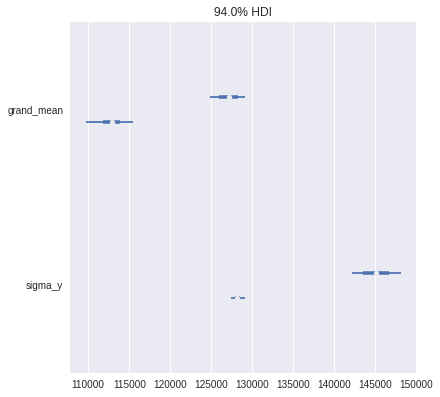

In [34]:
az.plot_forest(
    {
        "grand_mean": np.vstack(
            [
                grand_mean,
                np.random.uniform(124785, 129396, size=num_chains * num_samples),
            ]
        ),
        "sigma_y": np.vstack(
            [
                np.array(post_orig_scale["sigma_y"]),
                np.random.uniform(141929, 148248, size=num_chains * num_samples),
            ]
        ),
    }
);

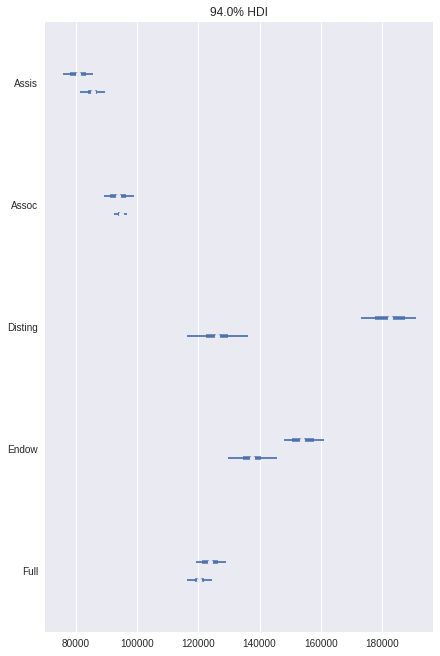

In [35]:
az.plot_forest(
    {
        "Assis": np.vstack(
            [
                main_effect_pos[:, 0] + grand_mean,
                np.random.uniform(75318, 86086, size=num_chains * num_samples),
            ]
        ),
        "Assoc": np.vstack(
            [
                main_effect_pos[:, 1] + grand_mean,
                np.random.uniform(88798, 99018, size=num_chains * num_samples),
            ]
        ),
        "Disting": np.vstack(
            [
                main_effect_pos[:, 2] + grand_mean,
                np.random.uniform(173189, 192066, size=num_chains * num_samples),
            ]
        ),
        "Endow": np.vstack(
            [
                main_effect_pos[:, 3] + grand_mean,
                np.random.uniform(147209, 160979, size=num_chains * num_samples),
            ]
        ),
        "Full": np.vstack(
            [
                main_effect_pos[:, 4] + grand_mean,
                np.random.uniform(118679, 129167, size=num_chains * num_samples),
            ]
        ),
    }
);

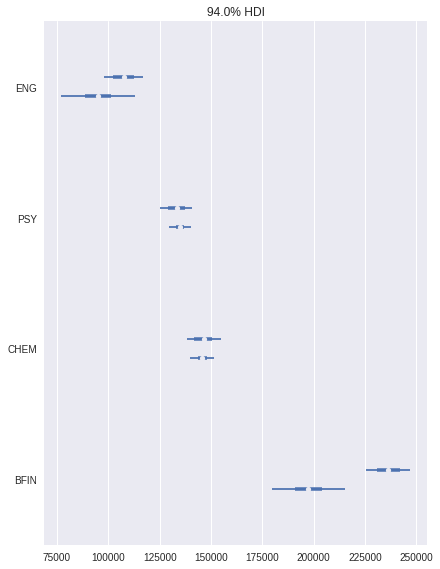

In [36]:
az.plot_forest(
    {
        "ENG": np.vstack(
            [
                main_effect_org[:, 20] + grand_mean,
                np.random.uniform(97369, 117584, size=num_chains * num_samples),
            ]
        ),
        "PSY": np.vstack(
            [
                main_effect_org[:, 48] + grand_mean,
                np.random.uniform(125138, 141890, size=num_chains * num_samples),
            ]
        ),
        "CHEM": np.vstack(
            [
                main_effect_org[:, 12] + grand_mean,
                np.random.uniform(137483, 154978, size=num_chains * num_samples),
            ]
        ),
        "BFIN": np.vstack(
            [
                main_effect_org[:, 7] + grand_mean,
                np.random.uniform(224970, 247975, size=num_chains * num_samples),
            ]
        ),
    }
);

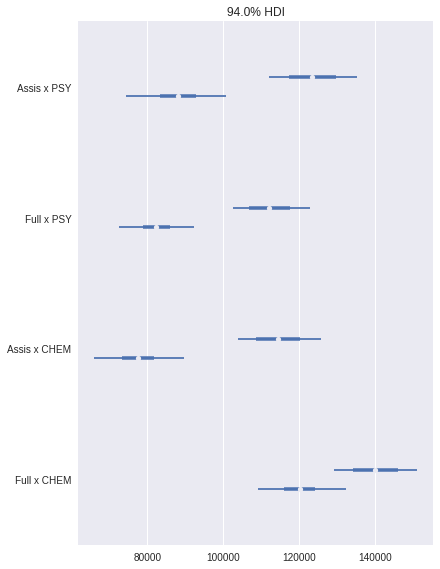

In [37]:
az.plot_forest(
    {
        "Assis x PSY": np.vstack(
            [
                interaction[:, 0, 48] + grand_mean,
                np.random.uniform(111197, 136078, size=num_chains * num_samples),
            ]
        ),
        "Full x PSY": np.vstack(
            [
                interaction[:, 4, 48] + grand_mean,
                np.random.uniform(101425, 122933, size=num_chains * num_samples),
            ]
        ),
        "Assis x CHEM": np.vstack(
            [
                interaction[:, 0, 12] + grand_mean,
                np.random.uniform(102634, 125939, size=num_chains * num_samples),
            ]
        ),
        "Full x CHEM": np.vstack(
            [
                interaction[:, 4, 12] + grand_mean,
                np.random.uniform(128256, 151636, size=num_chains * num_samples),
            ]
        ),
    }
);

In [38]:
post_means = pd.DataFrame(
    mcmc.get_samples()["cell_mean"].mean(0),
    columns=ct.named_transformers_["ordinal_encoder"].categories_[0],
    index=ct.named_transformers_["ordinal_encoder"].categories_[1],
)
post_mean_trf = pd.DataFrame(
    ct.named_transformers_["standard_salary"].inverse_transform(post_means),
    columns=ct.named_transformers_["ordinal_encoder"].categories_[0],
    index=ct.named_transformers_["ordinal_encoder"].categories_[1],
)
post_mean_trf.mean(1) - post_mean_trf.mean().mean()

Assis     -27259.304688
Assoc     -18194.718750
Disting    13238.109375
Endow      24706.351562
Full        7509.601562
dtype: float32

## Using Uniform for standard deviation of y

In [39]:
def cell_means_03(factor_00, factor_01, y=None):
    num_data = factor_00.shape[0]
    num_factor_00 = len(set(factor_00))
    num_factor_01 = len(set(factor_01))

    sigma_y = numpyro.sample("sigma_y", dist.Uniform(-2.5, 7.5))

    sigma_cell = numpyro.sample("sigma_cell", dist.Gamma(0.8, 0.3))

    with numpyro.plate("num_factor_01", num_factor_01):
        with numpyro.plate("num_factor_00", num_factor_00):
            cell_mean = numpyro.sample("cell_mean", dist.Normal(0, sigma_cell))

    with numpyro.plate("num_data", num_data):
        numpyro.sample(
            "obs", dist.Normal(cell_mean[factor_00, factor_01], sigma_y), obs=y
        )

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:02<00:00, 523.27it/s, 15 steps of size 3.46e-01. acc. prob=0.85] 



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
 cell_mean[0,0]      1.62      0.15      1.63      1.37      1.86   9041.84      1.00
 cell_mean[0,1]     -0.01      1.05     -0.03     -1.64      1.76   9983.64      1.00
 cell_mean[0,2]     -1.02      0.24     -1.02     -1.41     -0.64  10595.70      1.00
 cell_mean[0,3]     -0.75      0.37     -0.75     -1.37     -0.16  10150.40      1.00
 cell_mean[0,4]     -0.79      0.17     -0.79     -1.06     -0.50  10772.37      1.00
 cell_mean[0,5]     -0.82      0.38     -0.82     -1.41     -0.18  10716.63      1.00
 cell_mean[0,6]      0.38      0.23      0.38     -0.02      0.76   9255.64      1.00
 cell_mean[0,7]      1.92      0.16      1.92      1.67      2.18  10429.48      1.00
 cell_mean[0,8]     -0.75      0.12     -0.75     -0.94     -0.54  10413.45      1.00
 cell_mean[0,9]     -0.06      0.23     -0.06     -0.41      0.32   9188.17      1.00
cell_mean[0,10]     -0.95      0.15     -0.95     -1.

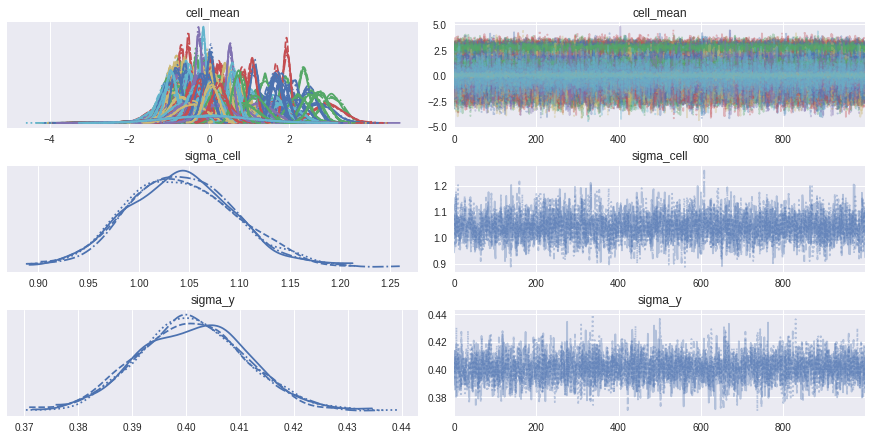

In [40]:
kernel = NUTS(cell_means_03)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(
    random.PRNGKey(4),
    jnp.array(salary_trf.Pos),
    jnp.array(salary_trf.Org),
    jnp.array(salary_trf.Salary),
)
mcmc.print_summary(exclude_deterministic=True)
ds_ = az.from_numpyro(mcmc)
az.plot_trace(ds_);

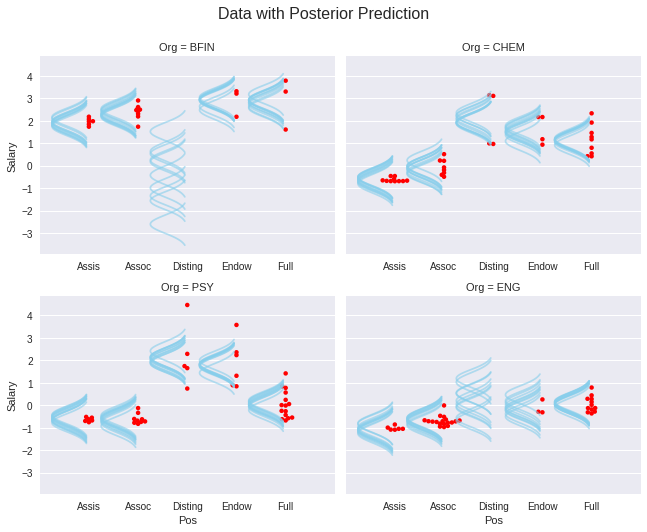

In [41]:
# BFIN = 7
# CHEM = 12
# PSY = 48
# ENG = 20
num_draws = 4000
subset_idx = [7, 12, 48, 20]
subset_df = salary_trf[salary_trf.Org.isin(subset_idx)].copy()
subset_org = ["BFIN", "CHEM", "PSY", "ENG"]

subset_df["Org"] = subset_df.Org.replace({7: "BFIN", 12: "CHEM", 48: "PSY", 20: "ENG"})
subset_df["Pos"] = subset_df.Pos.replace(
    {
        i: p
        for i, p in enumerate(ct.named_transformers_["ordinal_encoder"].categories_[1])
    }
)

fg = sns.FacetGrid(
    subset_df,
    col="Org",
    col_order=subset_org,
    col_wrap=2,
    height=3.5,
    aspect=1.3,
    despine=False,
    sharex=False,
)
fg.map(
    sns.swarmplot,
    "Pos",
    "Salary",
    data=subset_df,
    color="r",
    order=ct.named_transformers_["ordinal_encoder"].categories_[1].tolist(),
    size=4.5,
)
fg.fig.suptitle("Data with Posterior Prediction", y=1.05, fontsize=16)

for ax in fg.axes:
    ax.set_xlim(xmin=-1, xmax=5)
    ax.set_xticks(range(5),)
    # ax.set_xticklabels(ct.named_transformers_["ordinal_encoder"].categories_[1])

for i, org_idx in enumerate([7, 12, 48, 20]):
    for pos_idx in np.arange(5):
        plot_mustache(
            mcmc.get_samples()["cell_mean"][:num_draws, pos_idx, org_idx],
            mcmc.get_samples()["sigma_y"][:num_draws],
            pos_idx,
            ax=fg.axes.flatten()[i],
        )

In [42]:
post_orig_scale = {
    "cell_mean": ct.named_transformers_["standard_salary"].inverse_transform(
        np.array(mcmc.get_samples()["cell_mean"])
    ),
    "sigma_y": ct.named_transformers_["standard_salary"].inverse_transform(
        np.array(mcmc.get_samples()["sigma_y"])
    ),
    "sigma_cell": ct.named_transformers_["standard_salary"].inverse_transform(
        np.array(mcmc.get_samples()["sigma_cell"])
    ),
}

In [43]:
grand_mean = []
main_effect_pos = np.zeros((num_samples * num_chains, len(salary_trf.Pos.unique())))
main_effect_org = np.zeros((num_samples * num_chains, len(salary_trf.Org.unique())))
interaction = []

for i in range(num_samples * num_chains):
    g, r, c, inter = process_cell_means(post_orig_scale["cell_mean"][i, ...])
    main_effect_org[i, :] = r
    main_effect_pos[i, :] = c
    grand_mean.append(g)
    interaction.append(inter)

interaction = np.array(interaction)

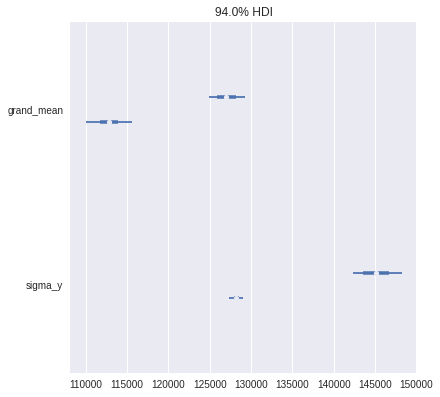

In [44]:
az.plot_forest(
    {
        "grand_mean": np.vstack(
            [
                grand_mean,
                np.random.uniform(124785, 129396, size=num_chains * num_samples),
            ]
        ),
        "sigma_y": np.vstack(
            [
                np.array(post_orig_scale["sigma_y"]),
                np.random.uniform(141929, 148248, size=num_chains * num_samples),
            ]
        ),
    }
);

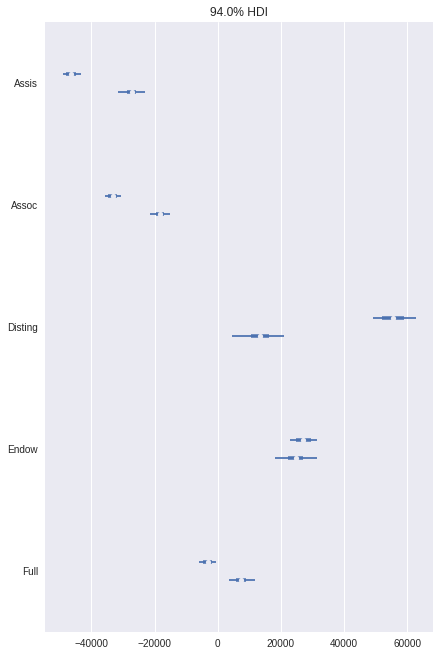

In [45]:
az.plot_forest(
    {
        "Assis": np.vstack(
            [
                main_effect_pos[:, 0],
                np.random.uniform(-49467, -43310, size=num_chains * num_samples),
            ]
        ),
        "Assoc": np.vstack(
            [
                main_effect_pos[:, 1],
                np.random.uniform(-35987, -30378, size=num_chains * num_samples),
            ]
        ),
        "Disting": np.vstack(
            [
                main_effect_pos[:, 2],
                np.random.uniform(48404, 62670, size=num_chains * num_samples),
            ]
        ),
        "Endow": np.vstack(
            [
                main_effect_pos[:, 3],
                np.random.uniform(22424, 31583, size=num_chains * num_samples),
            ]
        ),
        "Full": np.vstack(
            [
                main_effect_pos[:, 4],
                np.random.uniform(-6106, -229, size=num_chains * num_samples),
            ]
        ),
    }
);

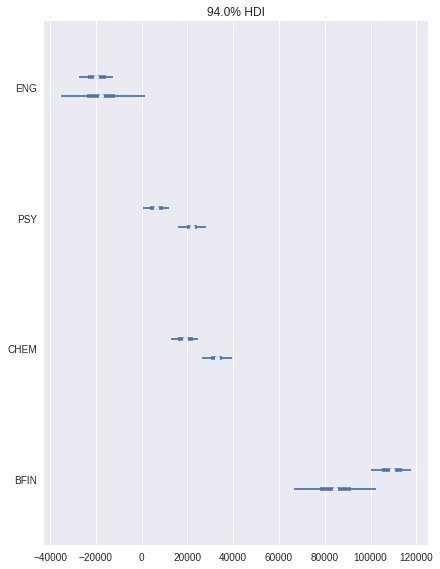

In [46]:
az.plot_forest(
    {
        "ENG": np.vstack(
            [
                main_effect_org[:, 20],
                np.random.uniform(-27416, -11812, size=num_chains * num_samples),
            ]
        ),
        "PSY": np.vstack(
            [
                main_effect_org[:, 48],
                np.random.uniform(353, 12494, size=num_chains * num_samples),
            ]
        ),
        "CHEM": np.vstack(
            [
                main_effect_org[:, 12],
                np.random.uniform(12698, 25582, size=num_chains * num_samples),
            ]
        ),
        "BFIN": np.vstack(
            [
                main_effect_org[:, 7],
                np.random.uniform(100185, 118579, size=num_chains * num_samples),
            ]
        ),
    }
);

In [47]:
from numpyro.diagnostics import print_summary

In [48]:
(interaction[:,0,48] + grand_mean)

array([86659.73 , 88858.27 , 97623.97 , ..., 90357.81 , 91205.52 ,
       86242.555], dtype=float32)

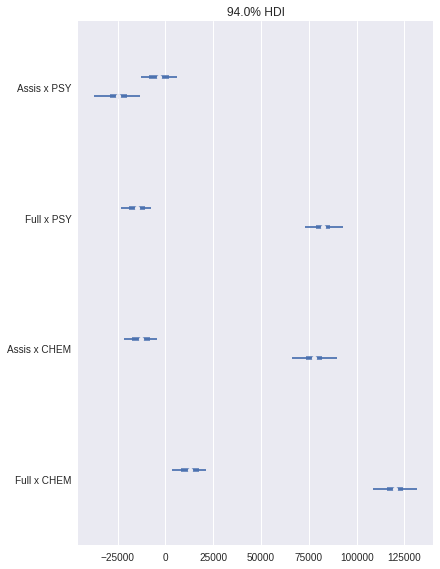

In [49]:
az.plot_forest(
    {
        "Assis x PSY": np.vstack(
            [
                interaction[:, 0, 48],
                np.random.uniform(-13588, 6682, size=num_chains * num_samples),
            ]
        ),
        "Full x PSY": np.vstack(
            [
                interaction[:, 4, 48] + grand_mean,
                np.random.uniform(-23360, -6463, size=num_chains * num_samples),
            ]
        ),
        "Assis x CHEM": np.vstack(
            [
                interaction[:, 0, 12] + grand_mean,
                np.random.uniform(-22151, -3457, size=num_chains * num_samples),
            ]
        ),
        "Full x CHEM": np.vstack(
            [
                interaction[:, 4, 12] + grand_mean,
                np.random.uniform(3471, 22240, size=num_chains * num_samples),
            ]
        ),
    }
);

In [50]:
ct.named_transformers_["ordinal_encoder"].categories_[1]

array(['Assis', 'Assoc', 'Disting', 'Endow', 'Full'], dtype=object)

In [51]:
ct.named_transformers_["ordinal_encoder"].categories_[0]

array(['ACTG', 'AFRO', 'AMST', 'ANTH', 'APHS', 'AST', 'BEPP', 'BFIN',
       'BI', 'BLAN', 'CEDP', 'CEUS', 'CHEM', 'CMCL', 'CMLT', 'CRIN',
       'CSCI', 'EALC', 'ECON', 'ELPS', 'ENG', 'FINH', 'FINS', 'FOLK',
       'FRIT', 'GEOG', 'GEOL', 'GERM', 'HIST', 'INFO', 'JOUR', 'KINE',
       'LAWS', 'LGED', 'LING', 'MATH', 'MGMT', 'MKTG', 'MUHI', 'MUIN',
       'MUST', 'MUTH', 'MUVO', 'OADT', 'OPT', 'PHYS', 'PL', 'POLS', 'PSY',
       'REL', 'RPAD', 'SLIS', 'SLS', 'SOC', 'SPAN', 'SPEA', 'SPHS',
       'STAT', 'TELC', 'THTR'], dtype=object)

## 20.2.3 - Main effect contrasts
### Figure 20.4

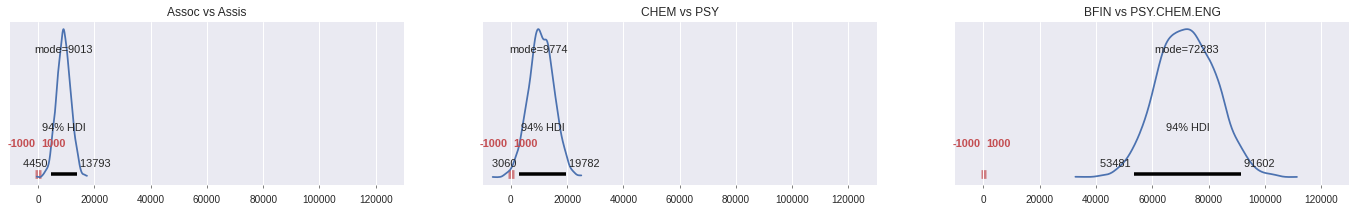

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(24, 3))
az.plot_posterior(
    {
        "Assoc vs Assis": main_effect_pos[:, 1] - main_effect_pos[:, 0],
        "CHEM vs PSY": main_effect_org[:, 12] - main_effect_org[:, 48],
        "BFIN vs PSY.CHEM.ENG": main_effect_org[:, 7]
        - (
            (main_effect_org[:, 48] + main_effect_org[:, 12] + main_effect_org[:, 20])
            / 3
        ),
    },
    rope=(-1000, 1000),
    point_estimate="mode",
    ax=ax,
)
for a in ax.flatten():
    a.set_xlim((-10000, 130000))

(-10000.0, 130000.0)

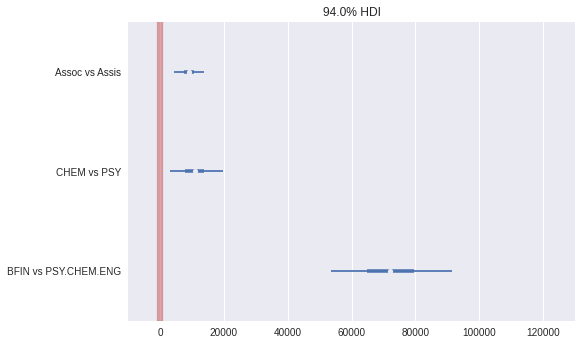

In [53]:
fig, ax = plt.subplots()
az.plot_forest(
    {
        "Assoc vs Assis": main_effect_pos[:, 1] - main_effect_pos[:, 0],
        "CHEM vs PSY": main_effect_org[:, 12] - main_effect_org[:, 48],
        "BFIN vs PSY.CHEM.ENG": main_effect_org[:, 7]
        - (
            (main_effect_org[:, 48] + main_effect_org[:, 12] + main_effect_org[:, 20])
            / 3
        ),
    },
    rope=(-1000, 1000),
    ax=ax,
)

ax.set_xlim((-10000, 130000))

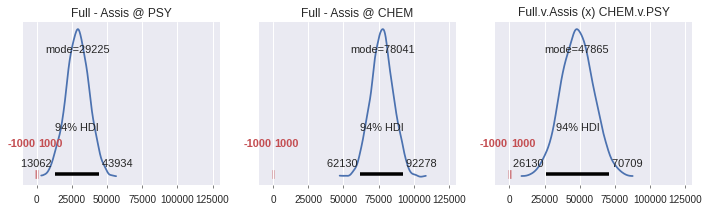

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
az.plot_posterior(
    {
        "Full - Assis @ PSY": post_orig_scale["cell_mean"][:, 4, 48]
        - post_orig_scale["cell_mean"][:, 0, 48],
        "Full - Assis @ CHEM": post_orig_scale["cell_mean"][:, 4, 12]
        - post_orig_scale["cell_mean"][:, 0, 12],
        "Full.v.Assis (x) CHEM.v.PSY": (
            post_orig_scale["cell_mean"][:, 4, 12]
            - post_orig_scale["cell_mean"][:, 0, 12]
        )
        - (
            post_orig_scale["cell_mean"][:, 4, 48]
            - post_orig_scale["cell_mean"][:, 0, 48]
        ),
    },
    rope=(-1000, 1000),
    point_estimate="mode",
    ax=ax,
)
for a in ax.flatten():
    a.set_xlim((-10000, 130000))

(-10000.0, 130000.0)

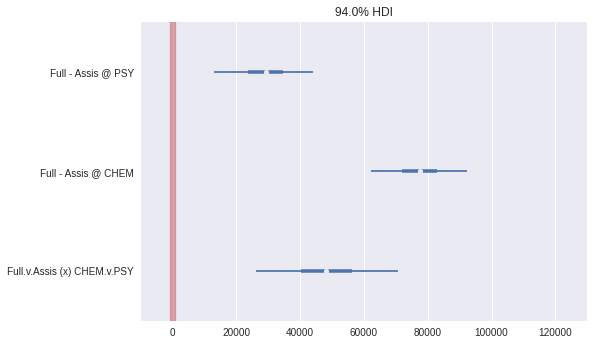

In [55]:
fig, ax = plt.subplots()
az.plot_forest(
    {
        "Full - Assis @ PSY": post_orig_scale["cell_mean"][:, 4, 48]
        - post_orig_scale["cell_mean"][:, 0, 48],
        "Full - Assis @ CHEM": post_orig_scale["cell_mean"][:, 4, 12]
        - post_orig_scale["cell_mean"][:, 0, 12],
        "Full.v.Assis (x) CHEM.v.PSY": (
            post_orig_scale["cell_mean"][:, 4, 12]
            - post_orig_scale["cell_mean"][:, 0, 12]
        )
        - (
            post_orig_scale["cell_mean"][:, 4, 48]
            - post_orig_scale["cell_mean"][:, 0, 48]
        ),
    },
    rope=(-1000, 1000),
    ax=ax,
)
ax.set_xlim((-10000, 130000))

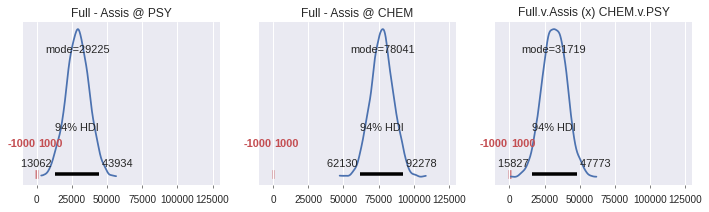

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
az.plot_posterior(
    {
        "Full - Assis @ PSY": post_orig_scale["cell_mean"][:, 4, 48]
        - post_orig_scale["cell_mean"][:, 0, 48],
        "Full - Assis @ CHEM": post_orig_scale["cell_mean"][:, 4, 12]
        - post_orig_scale["cell_mean"][:, 0, 12],
        "Full.v.Assis (x) CHEM.v.PSY": (interaction[:, 4, 12]) - (interaction[:, 0, 48])
    },
    rope=(-1000, 1000),
    point_estimate="mode",
    ax=ax,
)
for a in ax.flatten():
    a.set_xlim((-10000, 130000))

(-10000.0, 130000.0)

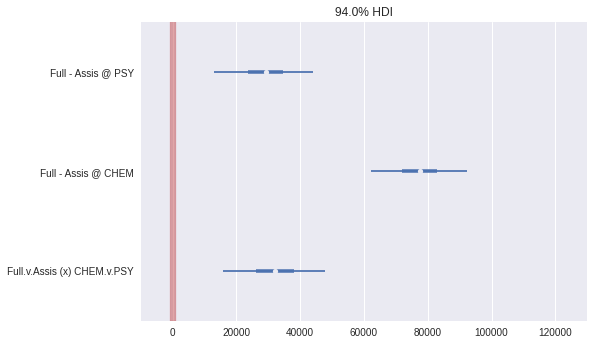

In [57]:
fig, ax = plt.subplots()
az.plot_forest(
    {
        "Full - Assis @ PSY": post_orig_scale["cell_mean"][:, 4, 48]
        - post_orig_scale["cell_mean"][:, 0, 48],
        "Full - Assis @ CHEM": post_orig_scale["cell_mean"][:, 4, 12]
        - post_orig_scale["cell_mean"][:, 0, 12],
        "Full.v.Assis (x) CHEM.v.PSY": (interaction[:, 4, 12]) - (interaction[:, 0, 48])
    },
    rope=(-1000, 1000),
    ax=ax,
)
ax.set_xlim((-10000, 130000))

## Factor effect model

In [58]:
salary

,Org,Pos,Salary,Pos_ID,Org_ID
0,PL,Assoc,72395.0,1,46
1,MUTH,Assoc,61017.0,1,41
2,ENG,Assoc,82370.0,1,20
3,CMLT,Assoc,68805.0,1,14
4,LGED,Assis,63796.0,0,33
...,...,...,...,...,...
1075,CSCI,Assis,92500.0,0,16
1076,PHYS,Assis,76748.0,0,45
1077,GEOL,Full,105786.0,2,26
1078,BI,Full,116592.0,2,8


In [59]:
y = salary.Salary
yMean = y.mean()
ySD = y.std()

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:18<00:00, 83.33it/s, 255 steps of size 1.74e-02. acc. prob=0.90] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
        a0_tilde      0.07      0.12      0.08     -0.12      0.28   1137.67      1.00
     a1_tilde[0]     -0.96      0.58     -0.94     -1.90     -0.02   1448.85      1.00
     a1_tilde[1]     -0.69      0.52     -0.68     -1.54      0.16   1375.99      1.00
     a1_tilde[2]     -0.06      0.46     -0.07     -0.78      0.71   1254.32      1.00
     a1_tilde[3]      0.57      0.50      0.56     -0.31      1.33   1275.81      1.00
     a1_tilde[4]      1.16      0.62      1.14      0.08      2.08   1319.08      1.00
 a1a2_tilde[0,0]      1.55      0.73      1.54      0.30      2.71   4371.11      1.00
 a1a2_tilde[0,1]     -0.02      0.97     -0.02     -1.69      1.54   5892.37      1.00
 a1a2_tilde[0,2]     -0.06      0.87     -0.08     -1.53      1.30   5278.78      1.00
 a1a2_tilde[0,3]      0.24      0.91      0.24     -1.34      1.65   6163.21      1.00
 a1a2_tilde[0,4]     -0.58      0.78     -

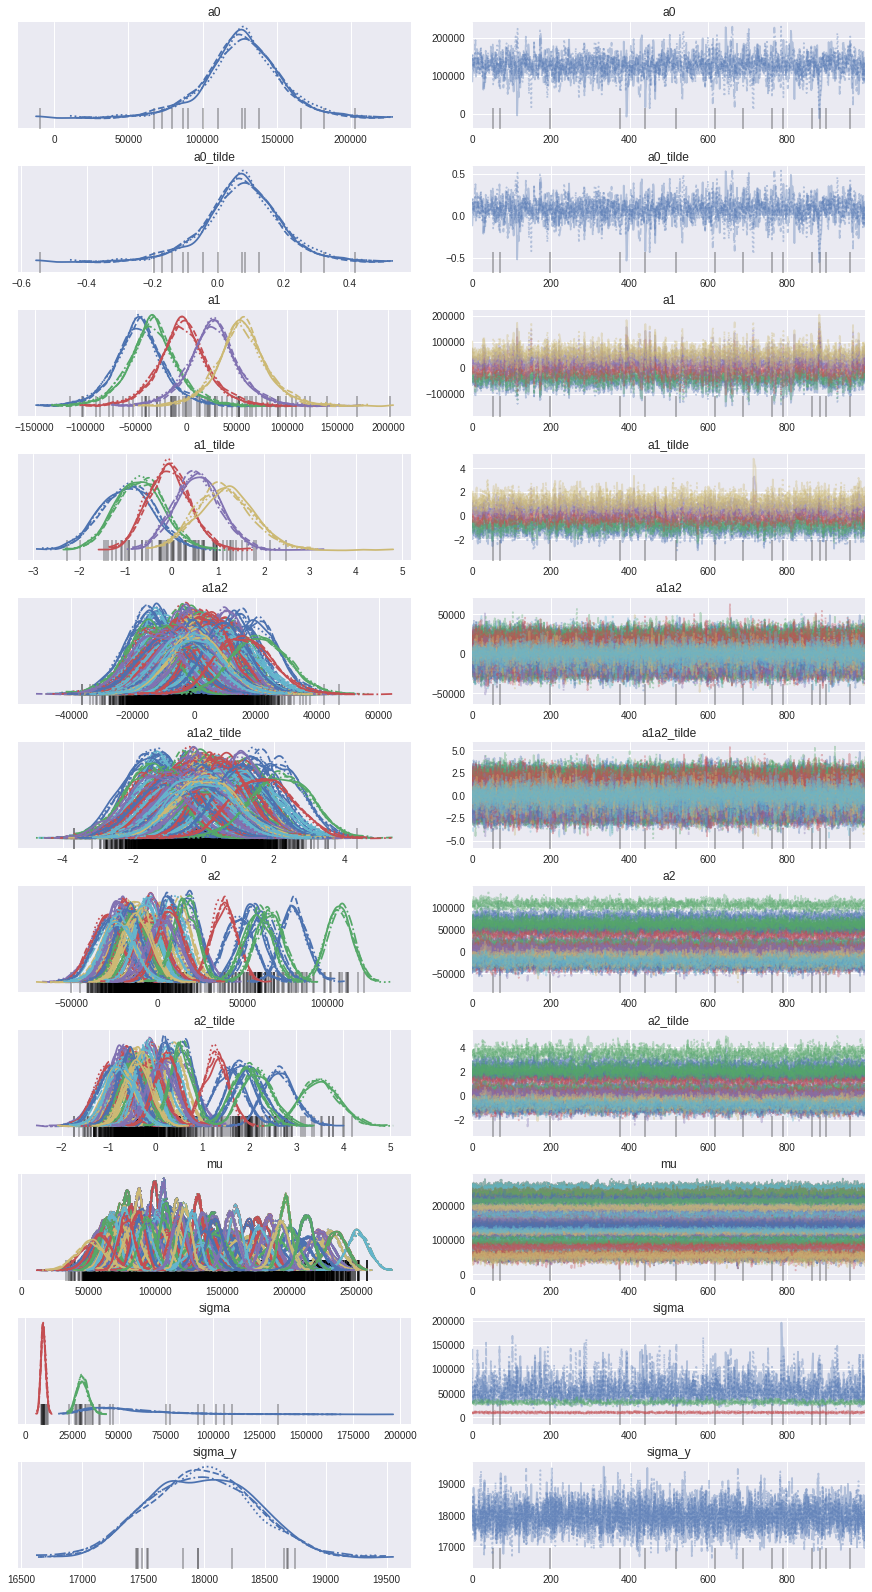

In [60]:
kernel = NUTS(factor_effect)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(
    random.PRNGKey(4),
    jnp.array(salary.Pos_ID),
    jnp.array(salary.Org_ID),
    ySD,
    yMean,
    jnp.array(salary.Salary),
)
mcmc.print_summary(exclude_deterministic=True)
ds_ = az.from_numpyro(mcmc)
az.plot_trace(ds_);

In [61]:
mcmc.get_samples().keys()

dict_keys(['a0', 'a0_tilde', 'a1', 'a1_tilde', 'a1a2', 'a1a2_tilde', 'a2', 'a2_tilde', 'mu', 'sigma', 'sigma_y'])

In [62]:
num_factor_00, num_factor_01 = len(set(salary.Pos)), len(set(salary.Org_ID))
m = np.zeros((num_factor_00, num_factor_01, num_samples*num_chains))
b1b2 = m.copy()

for (j1,j2) in np.ndindex(num_factor_00, num_factor_01):
    m[j1, j2] = mcmc.get_samples()["a0"] + mcmc.get_samples()["a1"][:, j1] + mcmc.get_samples()["a2"][:, j2] + mcmc.get_samples()["a1a2"][:, j1, j2]
    
b0 = np.mean(m, axis=(0,1))
b1 = np.mean(m, axis=1) - b0
b2 = np.mean(m, axis=0) - b0

for (j1,j2) in np.ndindex(num_factor_00, num_factor_01):
        b1b2[j1,j2] =  (m[j1,j2] - (b0 + b1[j1] + b2[j2]))
        
print('b0: {}'.format(np.round(np.mean(b0))))
print('b1: {}'.format(np.round(np.mean(b1, axis=1))))
print('b2: {}'.format(np.round(np.mean(b2, axis=1))[[20,48,12,7]]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[0,48]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[2,48]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[0,12]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[2,12]))
print('ySigma: {}'.format(np.round(np.mean(mcmc.get_samples()['sigma_y']))))

b0: 127079.0
b1: [-46322. -33081.  -3130.  27012.  55521.]
b2: [-19364.   6702.  19161. 109258.]
b1b2: -3354.0
b1b2: -15177.0
b1b2: -12774.0
b1b2: 13018.0
ySigma: 17980.0


In [63]:
b1b2.shape

(5, 60, 4000)

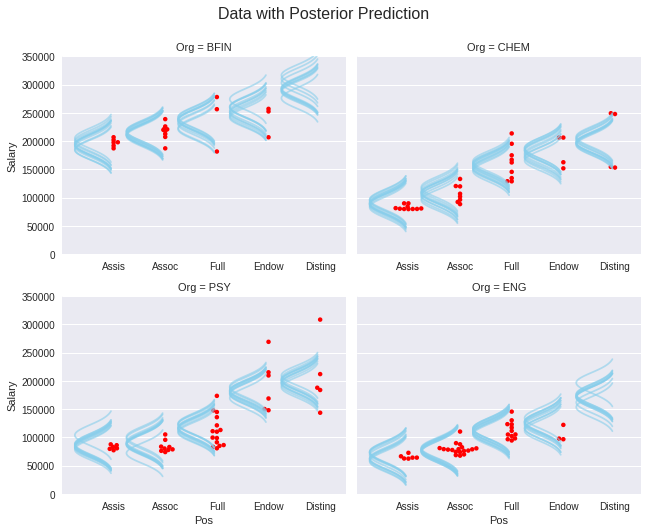

In [64]:
# BFIN = 7
# CHEM = 12
# PSY = 48
# ENG = 20
subset_org = ["BFIN", "CHEM", "PSY", "ENG"]
subset_df = salary[salary.Org.isin(subset_org)].copy()

fg = sns.FacetGrid(
    subset_df,
    col="Org",
    col_order=subset_org,
    col_wrap=2,
    height=3.5,
    aspect=1.3,
    despine=False,
    sharex=False,
)
fg.map(
    sns.swarmplot,
    "Pos",
    "Salary",
    data=subset_df,
    color="r",
    order=["Assis", "Assoc", "Full", "Endow", "Disting"],
    size=4.5,
)
fg.fig.suptitle("Data with Posterior Prediction", y=1.05, fontsize=16)

for ax in fg.axes:
    ax.set_xlim(xmin=-1,)
    ax.set_ylim((0, 350000))

for i, org_idx in enumerate([7, 12, 48, 20]):
    for pos_idx in np.arange(5):
        plot_mustache(
            b0+b1[pos_idx, :]+b2[org_idx, :] + b1b2[pos_idx, org_idx, :],
            mcmc.get_samples()["sigma_y"],
            pos_idx,
            ax=fg.axes.flatten()[i],
        )

In [65]:
m.shape

(5, 60, 4000)

In [66]:
post_orig_scale["cell_mean"].shape

(4000, 5, 60)

In [67]:
num_factor_00, num_factor_01 

(5, 60)

In [68]:
# Full vs Assis
P = np.zeros(num_factor_00, dtype=int)
P[salary.Pos.cat.categories == 'Full'] = 1
P[salary.Pos.cat.categories == 'Assis'] = -1

# CHEM vs PSY
O = np.zeros(num_factor_01, dtype=int)
O[salary.Org.cat.categories == 'CHEM'] = 1
O[salary.Org.cat.categories == 'PSY'] = -1

# The signs in the above vectors can be flipped, the end result (posterior) will be the same.
# Using the outer product of these two vectors, we get the matrix we need to multiply
# with the trace values of b1b2.
ic_factors = np.outer(P,O)
tmp = pd.DataFrame(ic_factors, index=salary.Pos.cat.categories, columns=salary.Org.cat.categories)

In [69]:
tmp[["CHEM", "PSY"]]

,CHEM,PSY
Assis,-1,1
Assoc,0,0
Full,1,-1
Endow,0,0
Disting,0,0


In [70]:
b1b2.shape

(5, 60, 4000)

In [71]:
np.tensordot(ic_factors, b1b2)

array([37760.765625 , 50673.9375   , 28087.515625 , ..., 36982.6484375,
       48644.8203125, 30284.15625  ])

In [72]:
post_orig_scale["cell_mean"].shape

(4000, 5, 60)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

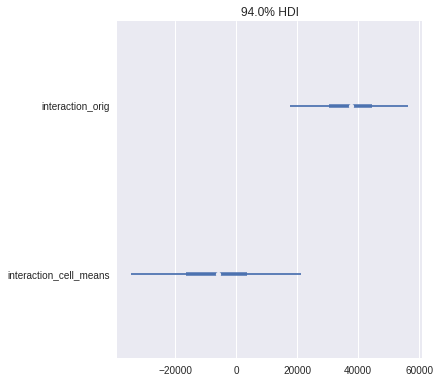

In [73]:
az.plot_forest({"interaction_orig": np.tensordot(ic_factors, b1b2), "interaction_cell_means": np.tensordot(interaction, ic_factors)})

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

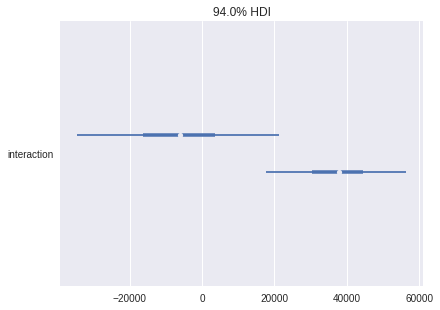

In [74]:
az.plot_forest({"interaction": np.vstack([np.tensordot(ic_factors, b1b2), np.tensordot(interaction, ic_factors)])})

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

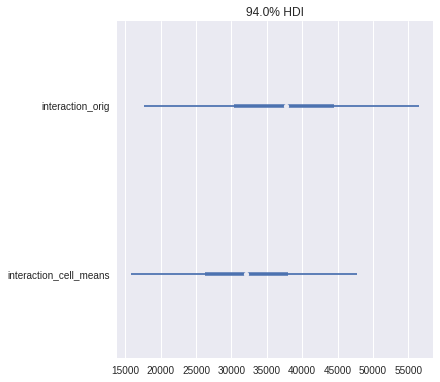

In [78]:
az.plot_forest({"interaction_orig": np.tensordot(ic_factors, b1b2), "interaction_cell_means": (interaction[:, 4, 12]) - (interaction[:, 0, 48])})

In [ ]:
fig, ax = plt.subplots()
az.plot_forest(
    {
        "Full - Assis @ PSY": post_orig_scale["cell_mean"][:, 4, 48]
        - post_orig_scale["cell_mean"][:, 0, 48],
        "Full - Assis @ CHEM": post_orig_scale["cell_mean"][:, 4, 12]
        - post_orig_scale["cell_mean"][:, 0, 12],
        "Full.v.Assis (x) CHEM.v.PSY": (interaction[:, 4, 12]) - (interaction[:, 0, 48])
    },
    rope=(-1000, 1000),
    ax=ax,
)
ax.set_xlim((-10000, 130000))